# 6. Wavelet

In [122]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pywt
import pywt.data
import math

In [51]:
def mse(A, B, ax=None):
    '''
    ax = 0: the average is performed along the row, for each column, returning an array
    ax = 1: the average is performed along the column, for each row, returning an array
    ax = None: the average is performed element-wise along the array, returning a scalar value
    '''
    return ((A - B)**2).mean(axis=ax)

In [49]:
def psnr(image, reference):
    image_float = np.float64(np.copy(image))
    reference_float = np.float64(np.copy(reference))
    pixel_max_value = 255.0

    mse_value = mse(image_float, reference_float)

    if mse_value == 0:
        return 100
    
    return 20 * math.log10(pixel_max_value / math.sqrt(mse_value))

In [3]:
src_path = './Images/6/Lena.bmp'
src = cv2.imread(src_path, cv2.IMREAD_GRAYSCALE)

## 6.1. Pyramid

**6.1.1. Given an image of size 𝑁 × 𝑁, where $𝑁 = 2^𝐽$, what is the maximum number of levels you can have in an
approximation pyramid representation? (The maximum level is reached when the coarsest level has only 1 pixel).
What is the total number of pixels in the pyramid (i.e. including pixels at all pyramid levels)? How does this
number compare with the original number of pixels in the image? Since this number is larger than the original
pixel number, what are some of the benefits of using the approximation pyramid? (give some examples). Repeat
the step for the prediction residual pyramid. Display and discuss the results.**

In [98]:
from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

x = src.astype(np.float32)
shape = x.shape

coef_list = []

max_lev = 9       # how many levels of decomposition to draw
label_levels = 9  # how many levels to explicitly label on the plots

approx_pyramid = []
prediction_pyramid = []

for level in range(0, max_lev + 1):
    if level == 0:
        continue

    c = pywt.wavedec2(x, 'haar', level=level)
    
    # normalize each coefficient array independently for better visibility
    c[0] /= np.abs(c[0]).max()
    for detail_level in range(level):
        c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
    
    approx_pyramid.append(c[0])
    
    arr, slices = pywt.coeffs_to_array(c)
    prediction_pyramid.append(arr)

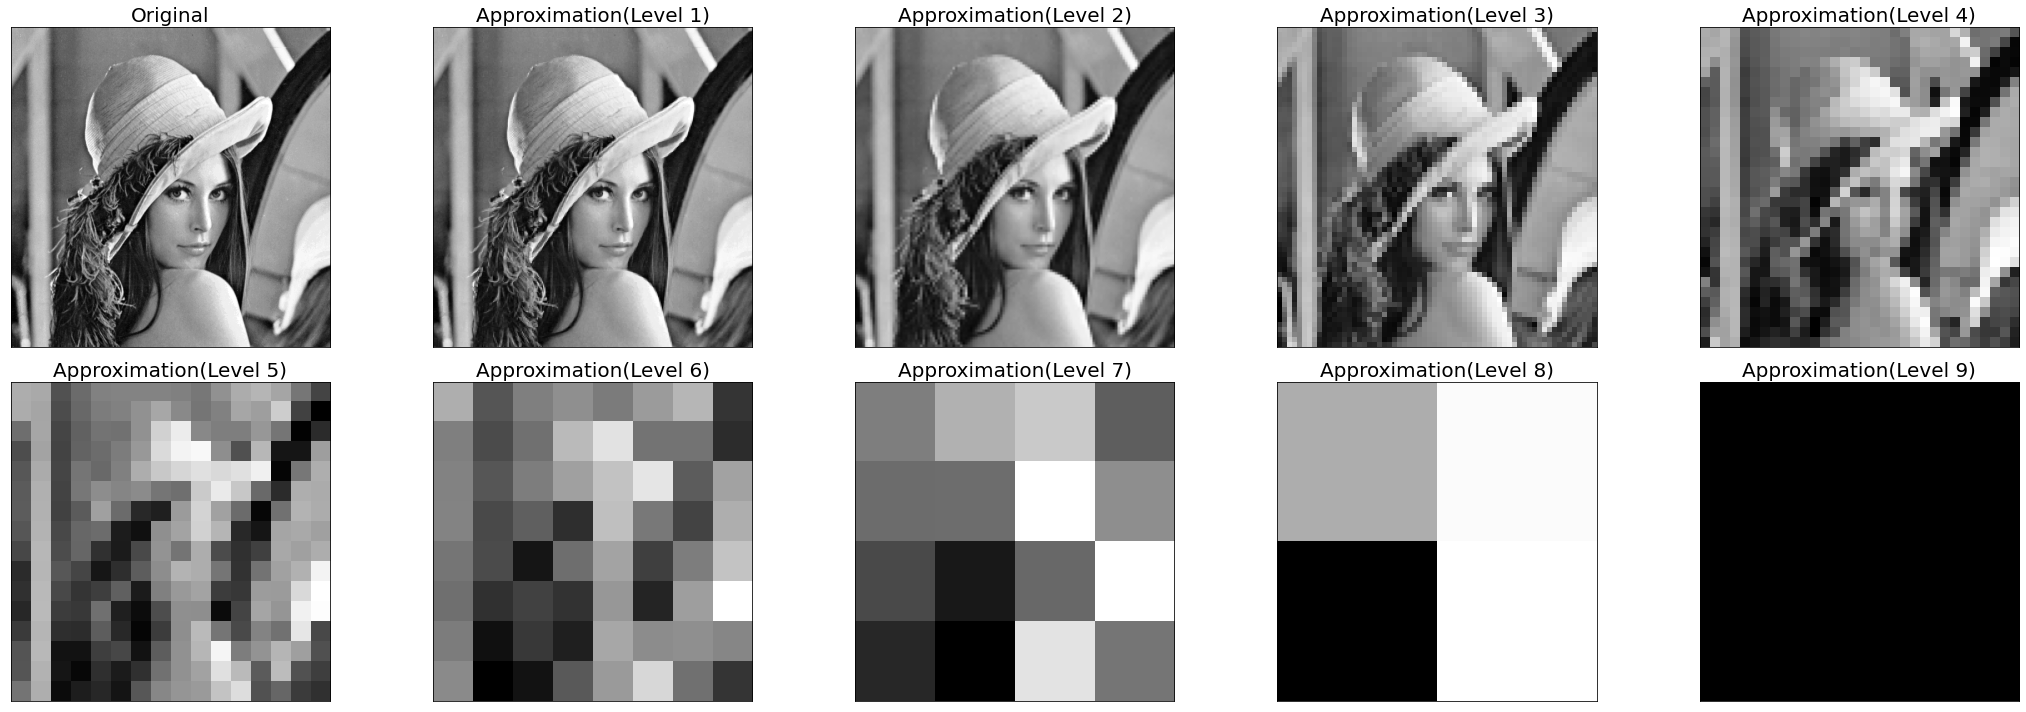

In [115]:
titles = ['Approximation(Level 1)', 'Approximation(Level 2)',
          'Approximation(Level 3)', 'Approximation(Level 4)',
          'Approximation(Level 5)', 'Approximation(Level 6)',
          'Approximation(Level 7)', 'Approximation(Level 8)',
          'Approximation(Level 9)']

fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(2, 5, 1)
ax.imshow(src, cmap=plt.cm.gray)
ax.set_title('Original', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

for i in range(len(approx_pyramid)):
    current_approx = approx_pyramid[i]
    ax = fig.add_subplot(2, 5, i + 2)
    ax.imshow(current_approx, cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

If we calculate the total number of pixels in the pyramid(including the original image), it will be:

$$1 + 4 + 16 + 64 + 256 + 1024 + 4096 + 16384 + 65536 + 262144$$

this is a geometric series with $a_1 = 1$ and common ratio $r = 4$. So it's sum will be:

$$S_n = \frac{a_1(1 - r^n)}{1 - r} = \frac {1 - 4^{10}}{1 - 4} = 349525$$

now if we divide it to the number of pixels in the original image:

$$ \frac {349525}{262144} = 1.333332061767578$$

this means we have $33$% more space computation in the pyramid than original image which is reasonable.

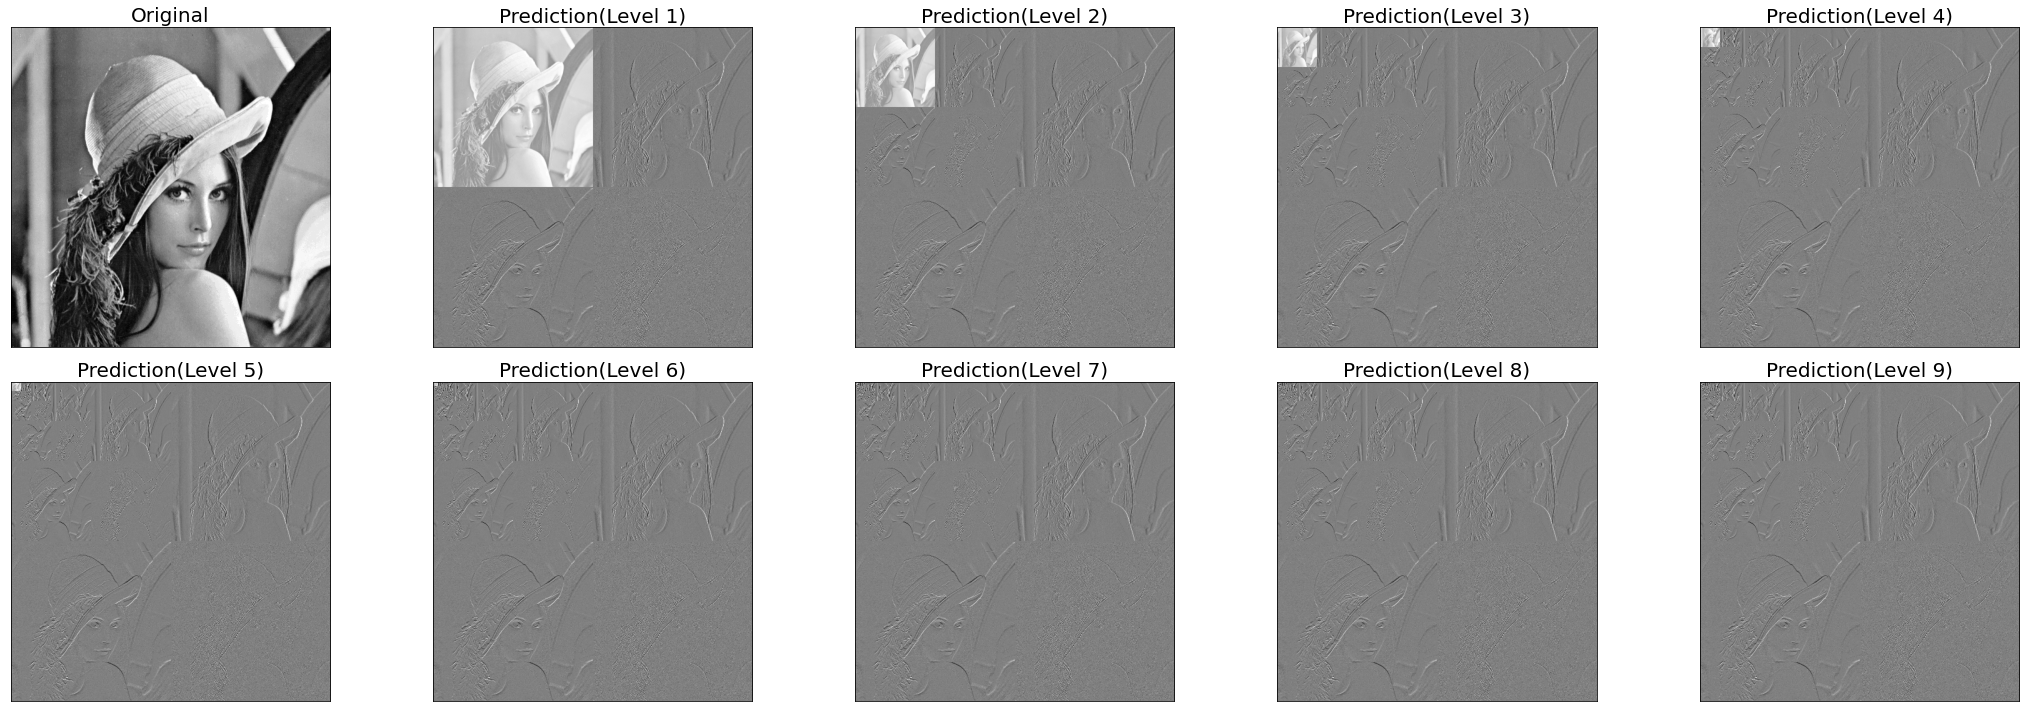

In [116]:
titles = ['Prediction(Level 1)', 'Prediction(Level 2)',
          'Prediction(Level 3)', 'Prediction(Level 4)',
          'Prediction(Level 5)', 'Prediction(Level 6)',
          'Prediction(Level 7)', 'Prediction(Level 8)',
          'Prediction(Level 9)']

fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(2, 5, 1)
ax.imshow(src, cmap=plt.cm.gray)
ax.set_title('Original', fontsize=20)
ax.set_xticks([])
ax.set_yticks([])

for i in range(len(prediction_pyramid)):
    current_pred = prediction_pyramid[i]
    ax = fig.add_subplot(2, 5, i + 2)
    ax.imshow(current_pred, cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

**6.1.2. For the grayscale Lena image, manually compute a 3-level approximation pyramid and corresponding prediction
residual pyramid. Use 2x2 averaging for the approximation and use pixel replication for the interpolation filters.**

In [77]:
def downsample_by_average_filter(src):
    height, width = src.shape
    dst_height, dst_width = (height // 2, width // 2)
    
    dst = np.zeros((dst_height, dst_width))
    
    for i in range(dst_height):
        for j in range(dst_width):
            block = src[2 * i: 2 * i + 2, 2 * j: 2 * j + 2]
            dst[i, j] = np.mean(block.flatten())
    
    return dst

In [78]:
def upsample_by_pixel_replication(src):
    height, width = src.shape
    dst_height, dst_width = (height * 2, width * 2)
    dst = np.zeros((dst_height, dst_width), dtype=int)
    
    for i in range(0, dst_height-1, 2):
        for j in range(0, dst_width-1, 2):
            dst[i, j] = src[i//2][j//2]
    
    for i in range(1, dst_height-1, 2):
        for j in range(0, dst_width-1):
            dst[i:i+1, j] = dst[i-1, j]
    
    for i in range(0, dst_height-1):
        for j in range(1, dst_width-1, 2):
            dst[i, j:j+1] = dst[i, j-1]

    return dst

In [80]:
approx_level_1 = downsample_by_average_filter(src)
prediction_residual_level_1 = src - upsample_by_pixel_replication(approx_level_1)

In [82]:
approx_level_2 = downsample_by_average_filter(approx_level_1)
prediction_residual_level_2 = approx_level_1 - upsample_by_pixel_replication(approx_level_2)

In [84]:
approx_level_3 = downsample_by_average_filter(approx_level_2)
prediction_residual_level_3 = approx_level_2 - upsample_by_pixel_replication(approx_level_3)

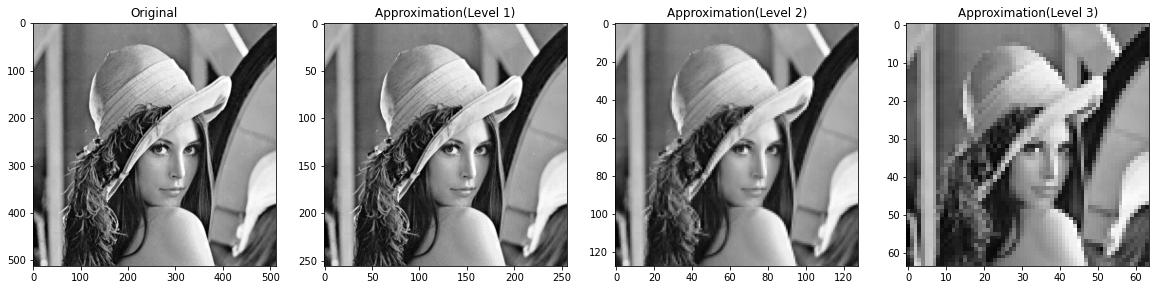

In [89]:
plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(src, cmap='gray')

plt.subplot(1, 4, 2)
plt.title("Approximation(Level 1)")
plt.imshow(approx_level_1, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("Approximation(Level 2)")
plt.imshow(approx_level_2, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("Approximation(Level 3)")
plt.imshow(approx_level_3, cmap='gray')

plt.show()

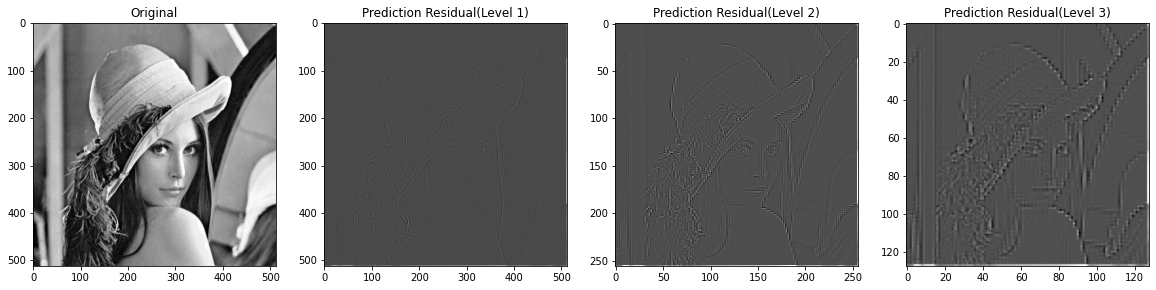

In [90]:
plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(src, cmap='gray')

plt.subplot(1, 4, 2)
plt.title("Prediction Residual(Level 1)")
plt.imshow(prediction_residual_level_1, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("Prediction Residual(Level 2)")
plt.imshow(prediction_residual_level_2, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("Prediction Residual(Level 3)")
plt.imshow(prediction_residual_level_3, cmap='gray')

plt.show()

In [93]:
cv2.imwrite('./Output Images/6/manual_approx_level_1.bmp', approx_level_1)
cv2.imwrite('./Output Images/6/manual_approx_level_2.bmp', approx_level_2)
cv2.imwrite('./Output Images/6/manual_approx_level_3.bmp', approx_level_3)

True

**6.1.3. For the grayscale Lena Image, compute the wavelet transform (with 3-level) using the Haar analysis filters.
Comment on the differences between the pyramids generated in Prob. 6.1.2 with the ones generated here.**

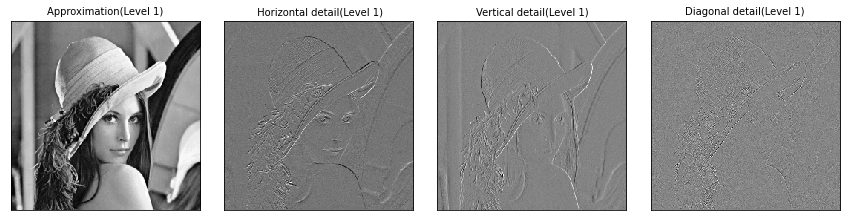

In [123]:
titles = ['Approximation(Level 1)', ' Horizontal detail(Level 1)',
          'Vertical detail(Level 1)', 'Diagonal detail(Level 1)']
coeffs2 = pywt.dwt2(src, 'haar')
LL1, (LH1, HL1, HH1) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL1, LH1, HL1, HH1]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

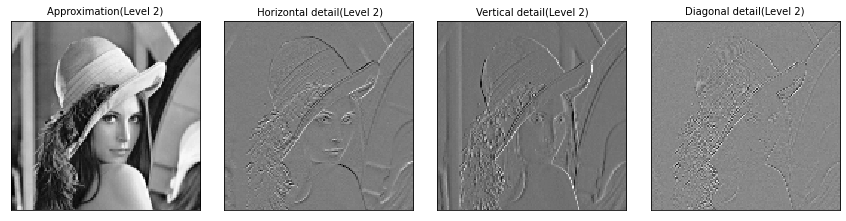

In [124]:
titles = ['Approximation(Level 2)', ' Horizontal detail(Level 2)',
          'Vertical detail(Level 2)', 'Diagonal detail(Level 2)']
coeffs2 = pywt.dwt2(LL1, 'haar')
LL2, (LH2, HL2, HH2) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL2, LH2, HL2, HH2]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

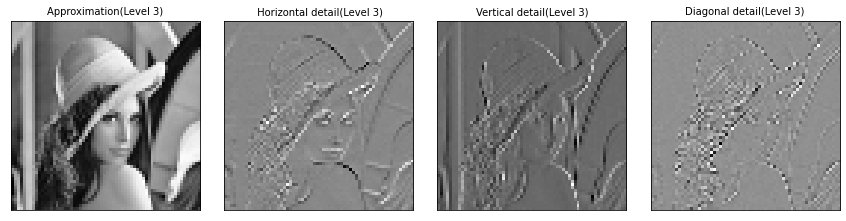

In [125]:
titles = ['Approximation(Level 3)', ' Horizontal detail(Level 3)',
          'Vertical detail(Level 3)', 'Diagonal detail(Level 3)']
coeffs2 = pywt.dwt2(LL2, 'haar')
LL3, (LH3, HL3, HH3) = coeffs2
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL3, LH3, HL3, HH3]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

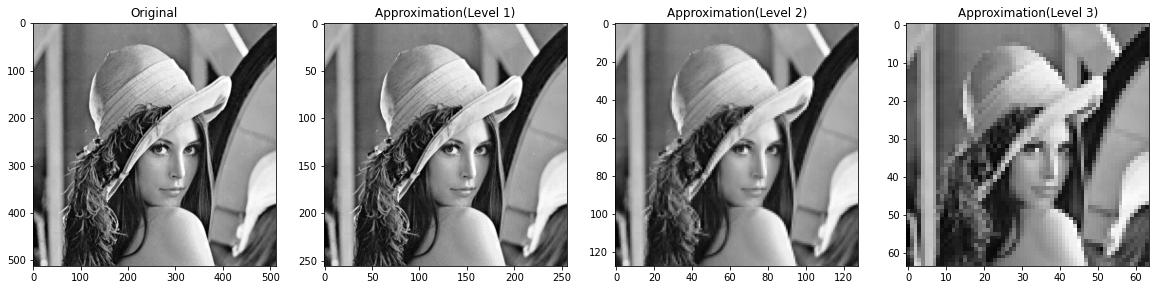

In [91]:
plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(src, cmap='gray')

plt.subplot(1, 4, 2)
plt.title("Approximation(Level 1)")
plt.imshow(LL1, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("Approximation(Level 2)")
plt.imshow(LL2, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("Approximation(Level 3)")
plt.imshow(LL3, cmap='gray')

plt.show()

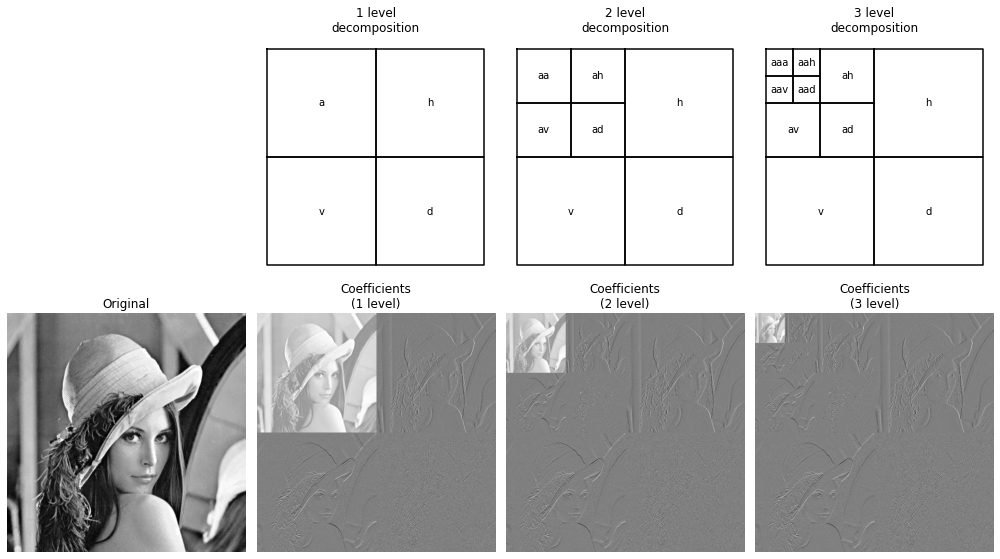

In [97]:
x = src.astype(np.float32)
shape = x.shape

coef_list = []

max_lev = 3
label_levels = 3

fig, axes = plt.subplots(2, 4, figsize=[14, 8])
for level in range(0, max_lev + 1):
    if level == 0:
        
        axes[0, 0].set_axis_off()
        axes[1, 0].imshow(x, cmap=plt.cm.gray)
        axes[1, 0].set_title('Original')
        axes[1, 0].set_axis_off()
        continue

    
    draw_2d_wp_basis(shape, wavedec2_keys(level), ax=axes[0, level],
                     label_levels=label_levels)
    axes[0, level].set_title('{} level\ndecomposition'.format(level))

    
    c = pywt.wavedec2(x, 'haar', level=level)
    
    
    c[0] /= np.abs(c[0]).max()
    for detail_level in range(level):
        c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
    
    
    arr, slices = pywt.coeffs_to_array(c)
    axes[1, level].imshow(arr, cmap=plt.cm.gray)
    axes[1, level].set_title('Coefficients\n({} level)'.format(level))
    axes[1, level].set_axis_off()

plt.tight_layout()
plt.show()

In [95]:
cv2.imwrite('./Output Images/6/haar_approx_level_1.bmp', LL1)
cv2.imwrite('./Output Images/6/haar_approx_level_2.bmp', LL2)
cv2.imwrite('./Output Images/6/haar_approx_level_3.bmp', LL3)

True

**6.1.4. Quantize all the wavelet coefficients (whole sub-bands) created in Prob. 6.1.3 by a step size of 𝛾 = 2. Then
reconstruct the image from the quantized wavelet coefficients using Haar synthesis filter. Report PSNR values
and discuss the results.**

**$$c^{\prime}(u,v) = \gamma \times sgn[c(u, v)] \times floor[\frac {|c(u,v)|}{\gamma}]$$**

**Note: you can use dwt2, idwt2, and psnr functions for problems 6.**

In [26]:
def quantize(coef, gamma = 2):
    height, width = coef.shape
    return np.array([[gamma * np.sign(coef[u, v]) * np.floor(np.abs(coef[u, v]) / gamma) for v in range(width)] for u in range(height)])

In [33]:
quantized_LL1 = quantize(LL1)
quantized_LH1 = quantize(LH1)
quantized_HL1 = quantize(HL1)
quantized_HH1 = quantize(HH1)

quantized_LL2 = quantize(LL2)
quantized_LH2 = quantize(LH2)
quantized_HL2 = quantize(HL2)
quantized_HH2 = quantize(HH2)

quantized_LL3 = quantize(LL3)
quantized_LH3 = quantize(LH3)
quantized_HL3 = quantize(HL3)
quantized_HH3 = quantize(HH3)

In [70]:
level1_coeffs = (quantized_LL1, (quantized_LH1, quantized_HL1, quantized_HH1))
reconstructed_from_level1 = pywt.idwt2(level1_coeffs, 'haar')

In [71]:
level2_coeffs = (quantized_LL2, (quantized_LH2, quantized_HL2, quantized_HH2))
LL1_reconstructed = pywt.idwt2(level2_coeffs, 'haar')
level1_coeffs = (LL1_reconstructed, (quantized_LH1, quantized_HL1, quantized_HH1))
reconstructed_from_level2 = pywt.idwt2(level1_coeffs, 'haar')

In [72]:
level3_coeffs = (quantized_LL3, (quantized_LH3, quantized_HL3, quantized_HH3))
LL2_reconstructed = pywt.idwt2(level3_coeffs, 'haar')
level2_coeffs = (LL2_reconstructed, (quantized_LH2, quantized_HL2, quantized_HH2))
LL1_reconstructed = pywt.idwt2(level2_coeffs, 'haar')
level1_coeffs = (LL1_reconstructed, (quantized_LH1, quantized_HL1, quantized_HH1))
reconstructed_from_level3 = pywt.idwt2(level1_coeffs, 'haar')

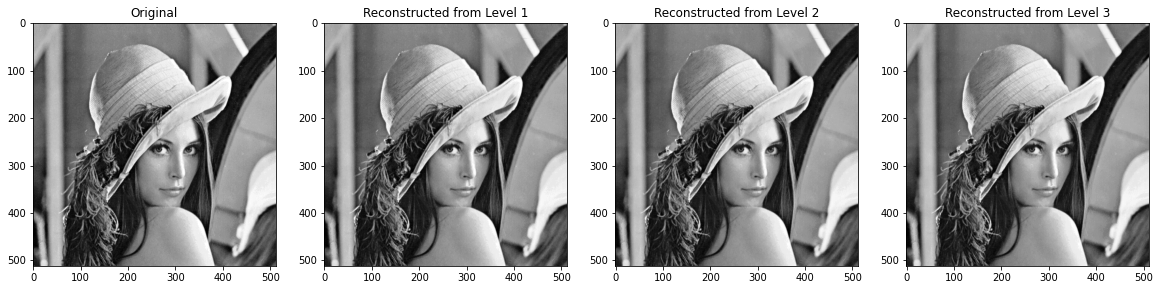

In [73]:
plt.figure(figsize=(20,10))

plt.subplot(1, 4, 1)
plt.title("Original")
plt.imshow(src, cmap='gray')

plt.subplot(1, 4, 2)
plt.title("Reconstructed from Level 1")
plt.imshow(reconstructed_from_level1, cmap='gray')

plt.subplot(1, 4, 3)
plt.title("Reconstructed from Level 2")
plt.imshow(reconstructed_from_level2, cmap='gray')

plt.subplot(1, 4, 4)
plt.title("Reconstructed from Level 3")
plt.imshow(reconstructed_from_level3, cmap='gray')

plt.show()

In [119]:
data = {
    'Original PSNR': [
        psnr(reconstructed_from_level1, src), 
        psnr(reconstructed_from_level2, src), 
        psnr(reconstructed_from_level3, src)
    ]   
}

index =['1 Level', '2 Levels', '3 Levels']

df = pd.DataFrame(data, index=index)

In [120]:
df.head()

Original PSNR
1 Level       48.296755
2 Levels      47.903730
3 Levels      47.859616

In [76]:
cv2.imwrite('./Output Images/6/Reconstructed_from_level_1.bmp', reconstructed_from_level1)
cv2.imwrite('./Output Images/6/Reconstructed_from_level_2.bmp', reconstructed_from_level2)
cv2.imwrite('./Output Images/6/Reconstructed_from_level_3.bmp', reconstructed_from_level3)

True

## 6.2. Denoising

**6.2.1. Implement at least two of the various image denoising techniques presented based on wavelet and compare
them on both synthetically noised image sequences and real-world (low-light) sequences. Does the performance
of the algorithm depend on the correct choice of noise level estimate? Can you draw any conclusions as to which
techniques work better? Note: You can freely use any function, toolbox or library. (Test on grayscale Lena Image).**

In [134]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio

In [148]:
original = img_as_float(src)

Estimated Gaussian noise standard deviation = 0.016117422887763848


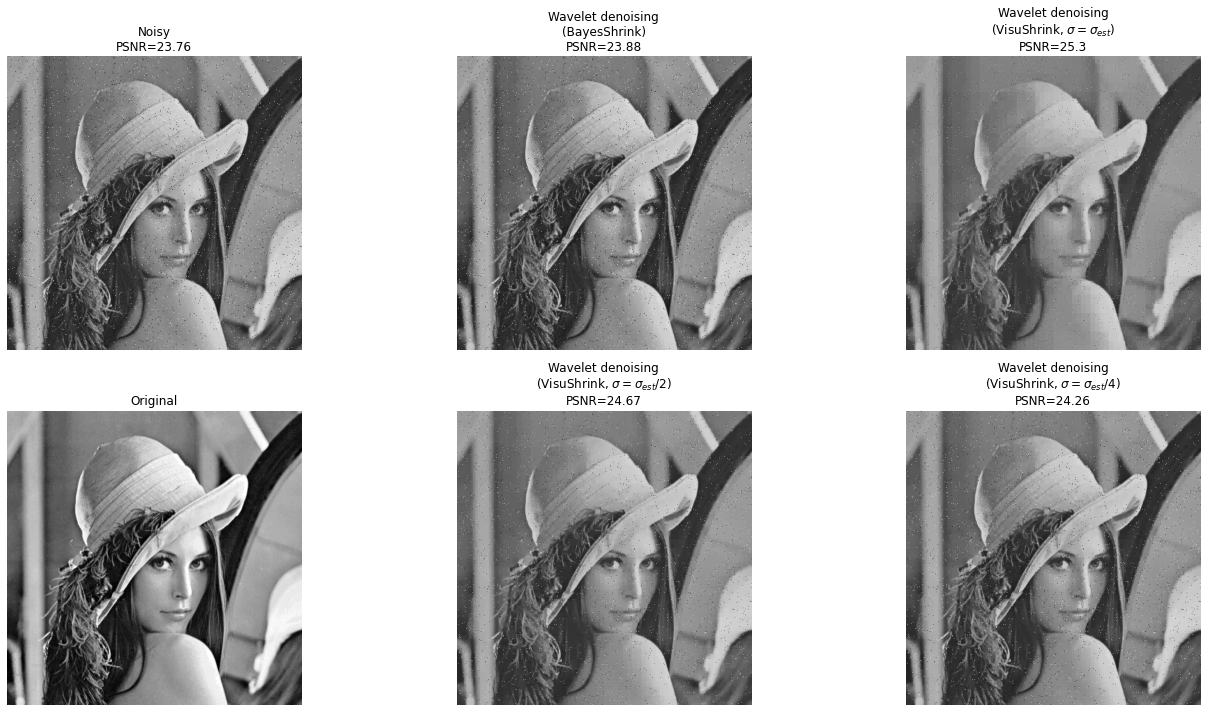

In [175]:
sigma = 0.12

# Add salt-and-pepper noise to the image
noisy = random_noise(original, mode='s&p', amount=sigma**2)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, average_sigmas=True)

# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

lena_bayes = denoise_wavelet(
    noisy,
    method='BayesShrink', 
    mode='soft',
    rescale_sigma=True
)

lena_visushrink = denoise_wavelet(
    noisy,
    method='VisuShrink', 
    mode='soft',
    sigma=sigma_est, 
    rescale_sigma=True
)

# VisuShrink is designed to eliminate noise with high probability, but this
# results in a visually over-smooth appearance.  Repeat, specifying a reduction
# in the threshold by factors of 2 and 4.
lena_visushrink2 = denoise_wavelet(
    noisy, 
    method='VisuShrink', 
    mode='soft',
    sigma=sigma_est/2, 
    rescale_sigma=True
)

lena_visushrink4 = denoise_wavelet(
    noisy, 
    method='VisuShrink', 
    mode='soft',
    sigma=sigma_est/4, 
    rescale_sigma=True
)

# Compute PSNR as an indication of image quality
psnr_noisy = peak_signal_noise_ratio(original, noisy)
psnr_bayes = peak_signal_noise_ratio(original, lena_bayes)
psnr_visushrink = peak_signal_noise_ratio(original, lena_visushrink)
psnr_visushrink2 = peak_signal_noise_ratio(original, lena_visushrink2)
psnr_visushrink4 = peak_signal_noise_ratio(original, lena_visushrink4)

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title(f'Noisy\nPSNR={psnr_noisy:0.4g}')
ax[0, 1].imshow(lena_bayes)
ax[0, 1].axis('off')
ax[0, 1].set_title(
    f'Wavelet denoising\n(BayesShrink)\nPSNR={psnr_bayes:0.4g}')
ax[0, 2].imshow(lena_visushrink)
ax[0, 2].axis('off')
ax[0, 2].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}$)\n'
     'PSNR=%0.4g' % psnr_visushrink)
ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')
ax[1, 1].imshow(lena_visushrink2)
ax[1, 1].axis('off')
ax[1, 1].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/2$)\n'
     'PSNR=%0.4g' % psnr_visushrink2)
ax[1, 2].imshow(lena_visushrink4)
ax[1, 2].axis('off')
ax[1, 2].set_title(
    'Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/4$)\n'
     'PSNR=%0.4g' % psnr_visushrink4)
fig.tight_layout()

plt.show()

In [176]:
cv2.imwrite('./Output Images/6/bayes_denoised_lena.bmp', lena_bayes)
cv2.imwrite('./Output Images/6/visu_denoised_lena_1.bmp', lena_visushrink)
cv2.imwrite('./Output Images/6/visu_denoised_lena_2.bmp', lena_visushrink2)
cv2.imwrite('./Output Images/6/visu_denoised_lena_4.bmp', lena_visushrink4)

True

In [160]:
my_image_path = './Images/3/my_image_01.jpg'
my_image = cv2.imread(my_image_path, cv2.IMREAD_GRAYSCALE)

In [161]:
my_float_image = img_as_float(my_image)

In [172]:
sigma_est = estimate_sigma(my_float_image, average_sigmas=True)
print(f'Estimated Gaussian noise standard deviation = {sigma_est}')

Estimated Gaussian noise standard deviation = 0.006099240089306375


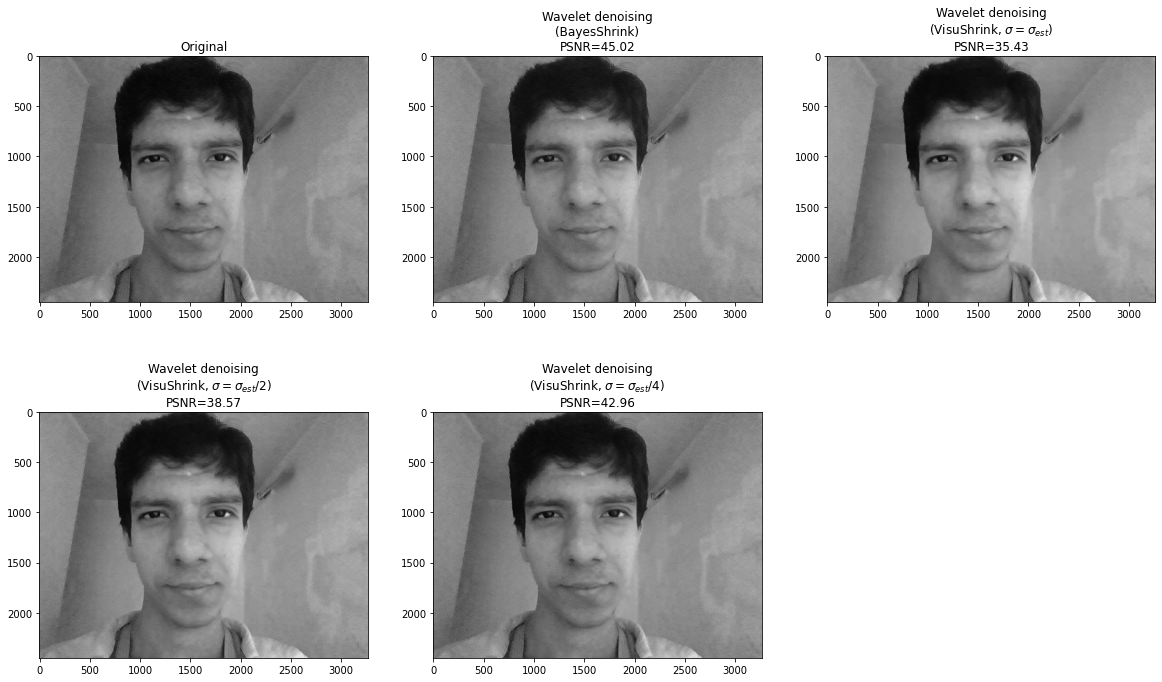

In [170]:
plt.figure(figsize=(20,12))

plt.subplot(2, 3, 1)
plt.title("Original")
plt.imshow(my_image, cmap='gray')

plt.subplot(2, 3, 2)
plt.title(f'Wavelet denoising\n(BayesShrink)\nPSNR={psnr_bayes:0.4g}')
plt.imshow(im_bayes, cmap='gray')

plt.subplot(2, 3, 3)
plt.title('Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}$)\n''PSNR=%0.4g' % psnr_visushrink)
plt.imshow(im_visushrink, cmap='gray')

plt.subplot(2, 3, 4)
plt.title('Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/2$)\n''PSNR=%0.4g' % psnr_visushrink2)
plt.imshow(im_visushrink2, cmap='gray')

plt.subplot(2, 3, 5)
plt.title('Wavelet denoising\n(VisuShrink, $\\sigma=\\sigma_{est}/4$)\n''PSNR=%0.4g' % psnr_visushrink4)
plt.imshow(im_visushrink4, cmap='gray')

plt.show()

In [177]:
cv2.imwrite('./Output Images/6/bayes_denoised_mohsen.bmp', im_bayes)
cv2.imwrite('./Output Images/6/visu_denoised_mohsen_1.bmp', im_visushrink)
cv2.imwrite('./Output Images/6/visu_denoised_mohsen_2.bmp', im_visushrink2)
cv2.imwrite('./Output Images/6/visu_denoised_mohsen_4.bmp', im_visushrink4)

True

## Resources

1. https://latex-tutorial.com/absolute-value-symbol/
2. http://www.malinc.se/math/latex/basiccodeen.php#:~:text=In%20LaTeX%20you%20use%20the,to%20make%20the%20symbol%20%C3%97.
3. https://pywavelets.readthedocs.io/en/latest/
4. https://pywavelets.readthedocs.io/en/latest/ref/2d-decompositions-overview.html
5. https://www.geeksforgeeks.org/numpy-floor-python/#:~:text=The%20numpy.,such%20that%20i%20%3C%3D%20x.&text=Return%20%3A%20The%20floor%20of%20each%20element.
6. https://www.geeksforgeeks.org/numpy-sign-in-python/#:~:text=sign()%20in%20Python,-Last%20Updated%20%3A%2003&text=03%20Oct%2C%202019-,numpy.,value%200%20it%20returns%200.
7. https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html
8. https://www.varsitytutors.com/hotmath/hotmath_help/topics/geometric-series#:~:text=To%20find%20the%20sum%20of,r%20is%20the%20common%20ratio%20.
9. https://stackoverflow.com/questions/59025386/how-to-add-synthetic-noise-in-an-image-with-specified-error-probability
https://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise_wavelet.html